In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
with open("training.pt", "rb") as file:
    analysis = pickle.load(file)
for k in analysis.keys(): print(k)

print("\nlength", len(analysis["loss_history"]))

loss_history
confidence

length 1004


In [3]:
batch_loss_mean = np.empty(len(analysis["loss_history"]))
for i in range(len(analysis["loss_history"])):
    if len(analysis["loss_history"][i]) != 0:
        batch_loss_mean[i] = np.mean(analysis["loss_history"][i])
    else:
        batch_loss_mean[i] = batch_loss_mean[i-1]

batch_cert_mean = np.empty(len(analysis["confidence"]))
for i in range(len(analysis["confidence"])):
    if len(analysis["confidence"][i]) != 0:
        batch_cert_mean[i] = np.mean(analysis["confidence"][i])
    else:
        batch_cert_mean[i] = batch_cert_mean[i-1]

In [4]:
N = 32

loss_mean = np.array([np.mean(chunk) for chunk in np.array_split(batch_loss_mean, N)])
loss_std = np.array([np.std(chunk) for chunk in np.array_split(batch_loss_mean, N)])

cert_mean = np.array([np.mean(chunk) for chunk in np.array_split(batch_cert_mean, N)])
cert_std = np.array([np.std(chunk) for chunk in np.array_split(batch_cert_mean, N)])

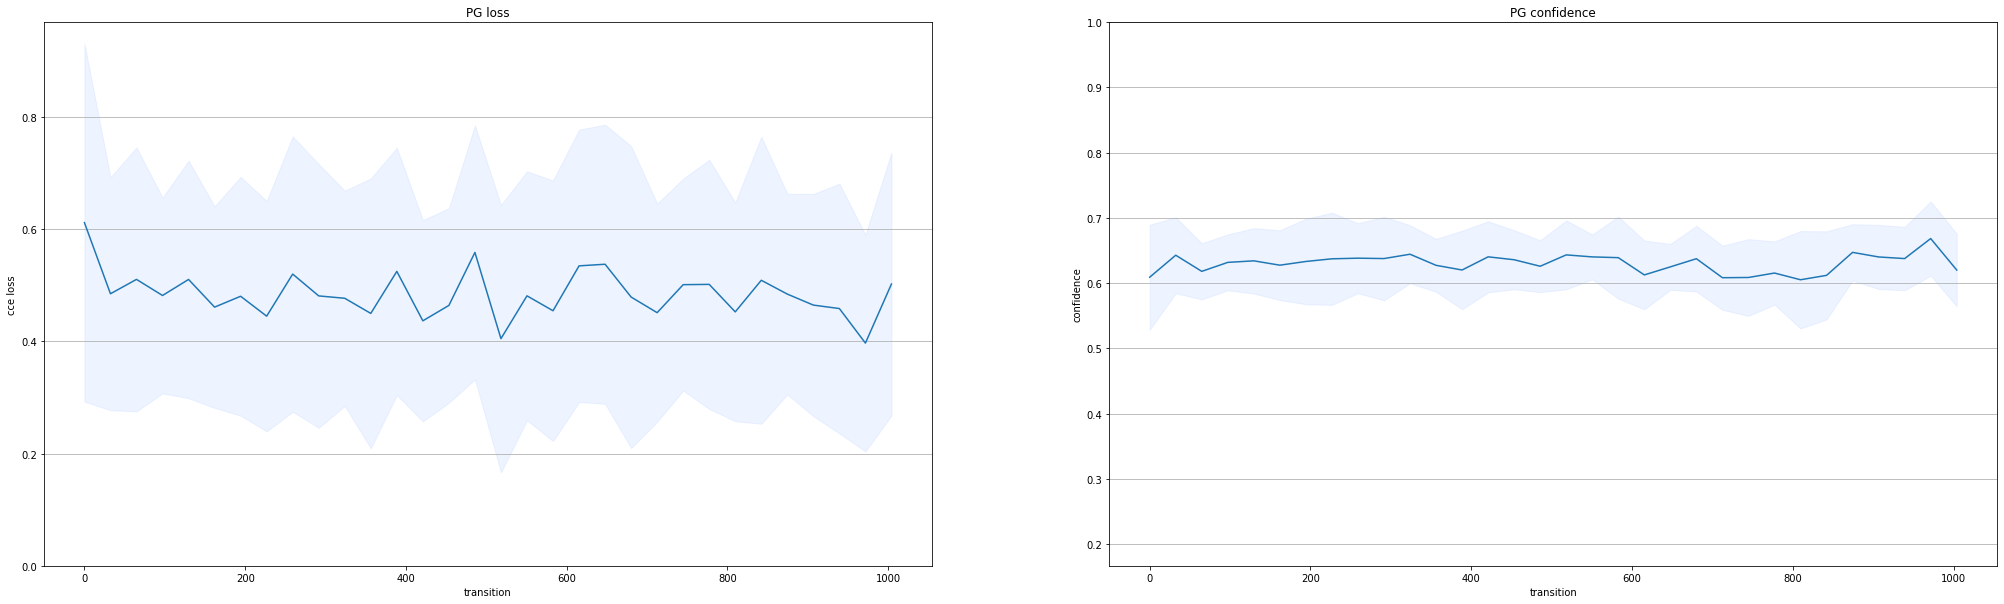

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(35, 10))

ax[0].plot(np.linspace(0, len(analysis["loss_history"]), N), loss_mean, label="mean loss")
ax[0].fill_between(np.linspace(0, len(analysis["loss_history"]), N), loss_mean - loss_std, loss_mean + loss_std, label="std loss", color="#bbd2ff", alpha=0.25)
ax[1].plot(np.linspace(0, len(analysis["confidence"]), N), cert_mean, label="mean confidence")
ax[1].fill_between(np.linspace(0, len(analysis["confidence"]), N), cert_mean - cert_std, cert_mean + cert_std, label="std confidence", color="#bbd2ff", alpha=0.25)

ax[0].set_xlabel("transition")
ax[1].set_xlabel("transition")

ax[0].set_ylabel("cce loss")
ax[1].set_ylabel("confidence")

ax[0].set_title("PG loss")
ax[1].set_title("PG confidence")

ax[0].grid(axis="y")
ax[1].grid(axis="y")

ax[0].set_ylim(0.0, None)
ax[1].set_ylim(1/6, 1);

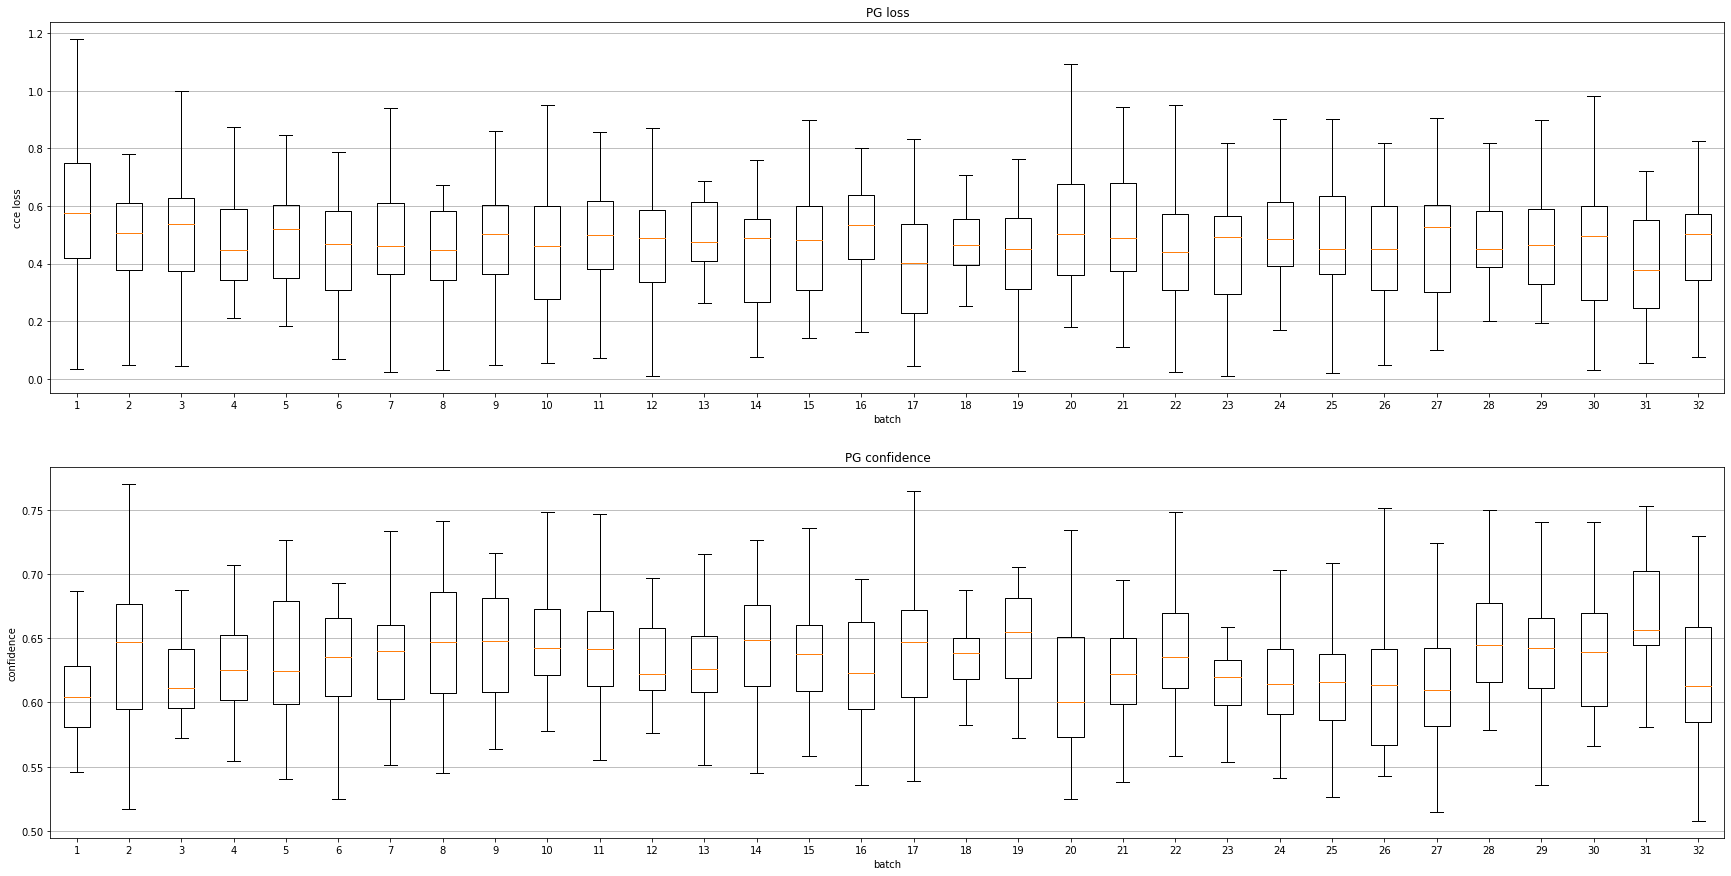

In [6]:
fig, ax = plt.subplots(2, 1, figsize=(30, 15))

ax[0].set_xlabel("batch")
ax[1].set_xlabel("batch")

ax[0].set_ylabel("cce loss")
ax[1].set_ylabel("confidence")

ax[0].set_title("PG loss")
ax[1].set_title("PG confidence")

ax[0].grid(axis="y")
ax[1].grid(axis="y")

ax[0].boxplot(np.array_split(batch_loss_mean, N), showfliers=False);
ax[1].boxplot(np.array_split(batch_cert_mean, N), showfliers=False);

In [7]:
im_weights = tf.keras.models.load_model("../../1_imitation/512-512-512_256-128/imitator").get_weights()
pg_weights = tf.keras.models.load_model("MCPG").get_weights()
# pg_1_weights = tf.keras.models.load_model("MCPG_batch_1_backup").get_weights()

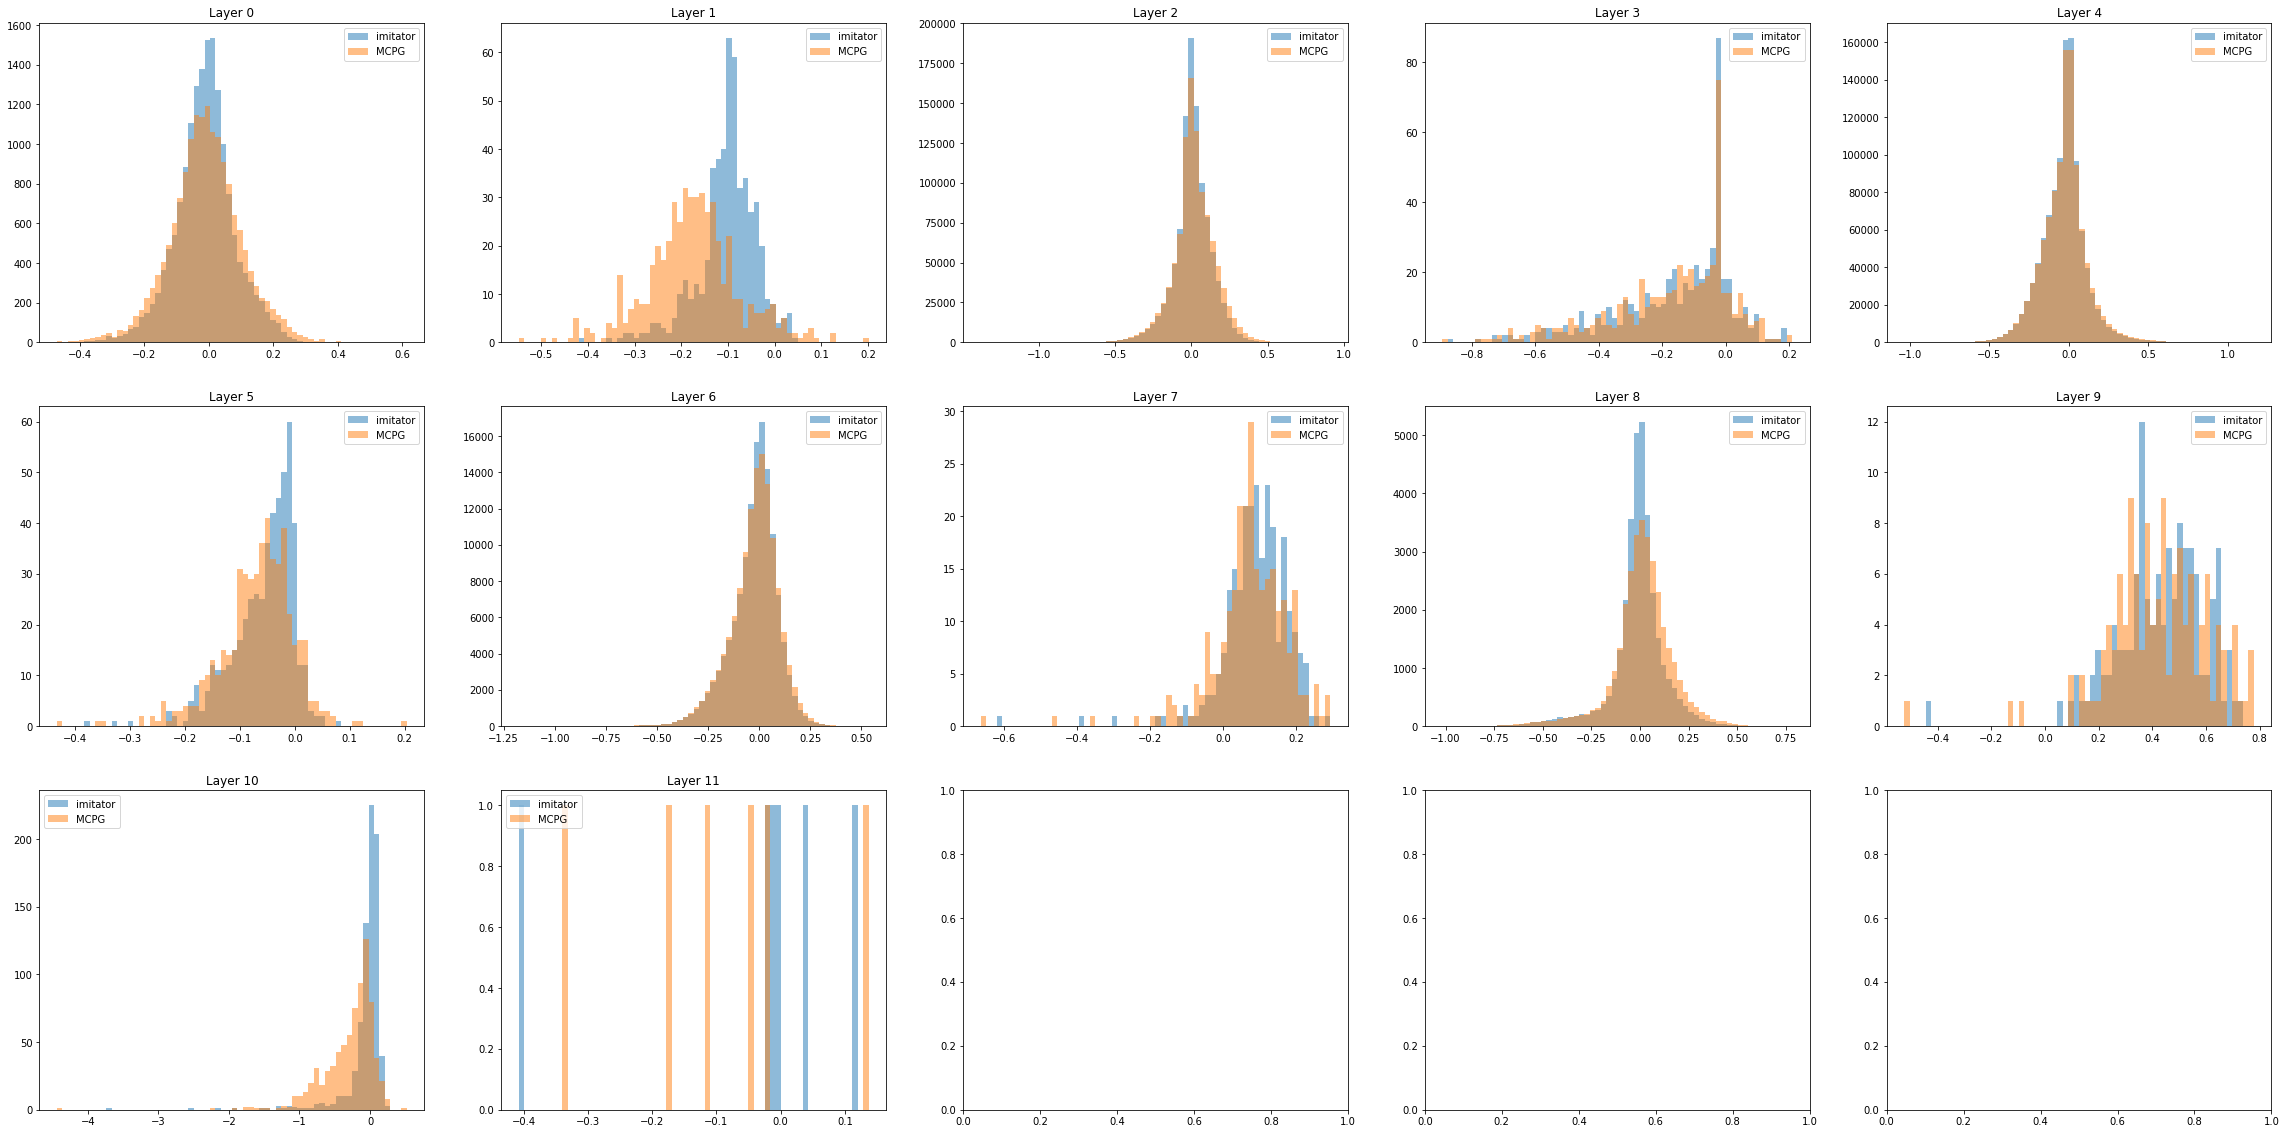

In [8]:
N = len(pg_weights)
COLS = 5
ROWS = int(np.ceil(N/COLS))
fig, ax = plt.subplots(ROWS, COLS, figsize=(40, 20))

for i in range(ROWS):
    for j in range(COLS):
        if i * COLS + j < N:
            bins = np.histogram(np.hstack((pg_weights[i * COLS + j], im_weights[i * COLS + j])), bins=64)[1]
            ax[i][j].hist(im_weights[i * COLS + j].ravel(), bins=bins, alpha=0.5, label="imitator")
            ax[i][j].hist(pg_weights[i * COLS + j].ravel(), bins=bins, alpha=0.5, label="MCPG")
            # ax[i][j].hist(pg_1_weights[i * COLS + j].ravel(), bins=bins, alpha=0.3, label="MCPG_b1")
            ax[i][j].set_title(f"Layer {i * COLS + j}")
            ax[i][j].legend()